In [1]:
import numpy as np
import h5py
import netCDF4 as nc
import oceanDAS as odas
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone
from scipy import signal

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'

plt.rc('font', size=12) 

In [2]:
def calc_Dspec(das,dasTime,t1,C,C_frq):
    fs = 1/(dasTime[1]-dasTime[0])
    das = das[(dasTime>=t1) & (dasTime<(t1+60*60))]
    frq,psd_das = signal.welch(das,fs=fs,window='hann',nperseg=fs*60*5,detrend=False)

    # correct from PSD of strain to PSD of pressure
    C = np.interp(frq,C_frq,C)
    psd_dasp = C*psd_das
    
    return frq, psd_das, psd_dasp
def calc_Pspec(press,presTime,t1):
    fs = 1/(presTime[1]-presTime[0])
    press = press[(presTime>=t1) & (presTime<(t1+60*60))]
    frq,psd = signal.welch(press,fs=fs,window='hann',nperseg=fs*60*5,detrend=False)

    return frq, psd

def calc_nrmse(ctrl,pred):
    rmse = np.sqrt(np.mean((ctrl-pred)**2))
    nrmse = rmse/np.mean(ctrl)
    return nrmse

In [3]:
# Duck
pname = 'DuckNC_Glover/'

t1 = datetime(2021, 11, 12, 0, 0, 0,tzinfo=timezone.utc).timestamp()
# load pressure
with np.load(pname+'FRF-ocean_waveTs_awac-11m_202111.npz') as data:
    press = data['p']
    presTime = data['t']
frq_p, psd_p = calc_Pspec(press,presTime,t1)

# load strain
f = h5py.File(pname + 'ChNo436_Nov2021fromdown.hdf5', 'r') 
dasTime = f['Acquisition']['RawDataTime'][:]
das = f['Acquisition']['RawData'][:] # unit of E

# load correction factor
with np.load(pname+'empCalNov_all.npz') as data:
    C_frq = data['x']
    C = data['y'][381,:]
frq_d, psd_d, psd_dp = calc_Dspec(das,dasTime,t1,C,C_frq)


# make the figure
plt.ioff()
fig,ax = plt.subplots(3,1,figsize=(10,10))
ax = ax.ravel()

# plot example with close calibration point
jj=0
ax[jj].plot(frq_d,psd_d,'b',linewidth=2)
ax2 = ax[jj].twinx()
ax2.plot(frq_d,psd_dp,c = 'tab:gray',linewidth=2,linestyle='--',label='DAS-Nearest')
ax2.plot(frq_p,psd_p,c = 'k',linewidth=2.5,label='pressure')
ax2.set_ylim([1e-5,5])
ax[jj].set_ylim([3e-14,3e-10])
ax2.set_yscale('log')
ax2.legend()

# calculate nrmse
psd_dp = np.interp(frq_p,frq_d,psd_dp)
idx = frq_p<0.04
print(calc_nrmse(psd_p[idx],psd_dp[idx]))
idx = (frq_p>0.04) & (frq_p<0.25)
print(calc_nrmse(psd_p[idx],psd_dp[idx]))
idx = frq_p>0.25
print(calc_nrmse(psd_p[idx],psd_dp[idx]))

1.2796645363344257
0.43218903682601645
2.2093206935943632


In [4]:
# KNO
pname = 'KNO_Glover/'

t1 = datetime(2023, 1, 17, 4, 0, 0,tzinfo=timezone.utc).timestamp()
# load pressure
with np.load(pname + 'rbr_pres_temp_all.npz') as data:
    press = data['p'][:,5] #5 is nearest ch124, h=11.5 m
    presTime = data['tvec']
# calculate spectra for pressure
frq_p, psd_p = calc_Pspec(press,presTime,t1)

# load strain data
chno = 124
f = h5py.File(pname+'downsampFilt_F1_01-17-2023.hdf5', 'r')
das = f['Acquisition']['RawData'][:,chno]
dasTime = f['Acquisition']['RawDataTime'][:]

# load correction factor for chno = 124, Fiber 1,
with np.load(pname+'empCal_all_F1.npz') as data:
    C_frq = data['frq']
    C = data['sf'][chno-40,:].flatten()

# calculate spectra for corrected (pressure) and uncorrected (strain)
frq_d, psd_d, psd_dp = calc_Dspec(das,dasTime,t1,C,C_frq)

# plot example with close calibration point
jj = 1
ax[jj].plot(frq_d,psd_d,'b',linewidth=2)
ax2 = ax[jj].twinx()
ax2.plot(frq_d,psd_dp,c = 'tab:gray',linewidth=2,linestyle='--')
ax2.plot(frq_p,psd_p,c = 'k',linewidth=2.5)
ax2.set_ylim([1e-5,5])
ax[jj].set_ylim([1e-14,6e-12])
ax2.set_yscale('log')


# calculate nrmse
psd_dp = np.interp(frq_p,frq_d,psd_dp)
idx = (frq_p<0.04) & np.isfinite(psd_dp)
print(calc_nrmse(psd_p[idx],psd_dp[idx]))
idx = (frq_p>0.04) & (frq_p<0.25)
print(calc_nrmse(psd_p[idx],psd_dp[idx]))
idx = frq_p>0.25
print(calc_nrmse(psd_p[idx],psd_dp[idx]))

2.582001608011849
0.8066172940291426
128.4374914789693


3.1622688348514423
0.42798530365610066
0.758489194470932


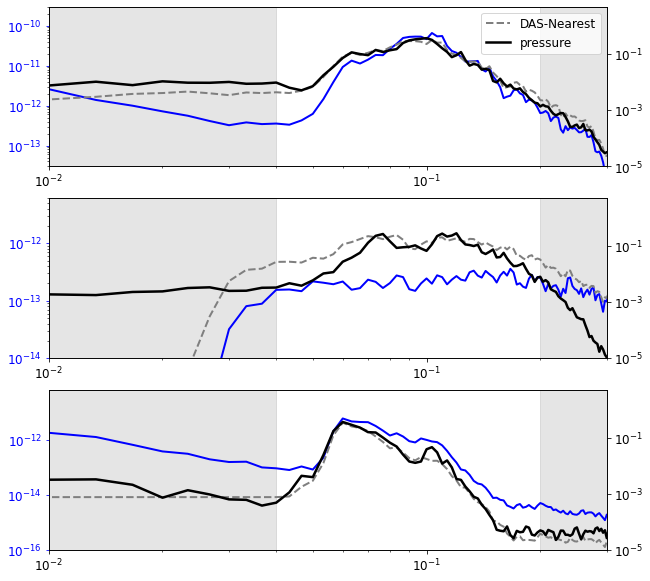

In [5]:
###### Flo
pname = 'FlorenceOR_Ifju/'

t1 = datetime(2022, 9, 28, 0, 0, 0,tzinfo=timezone.utc).timestamp()

fname = pname+'adcp250_pressure.csv'
f = np.genfromtxt(fname, delimiter=',')
presTime = f[:,0]+(8*60*60)
press = f[:,1]
frq_p, psd_p = calc_Pspec(press,presTime,t1)

fname = pname+'downsamp_0927-0930_ch700.npz'
with np.load(fname) as data:
    dasTime = data['t']
    das = data['r7008']
depth = 50 # from metadata

# load correction factor for chno = 700
with np.load(pname+'empCal_Ch700_Flo.npz') as data:
    C_frq = data['frq']
    C = data['sf']

# calculate spectra for corrected (pressure) and uncorrected (strain)
frq_d, psd_d, psd_dp = calc_Dspec(das,dasTime,t1,C,C_frq)

ind = np.where(~np.isnan(psd_dp))[0]
psd_dp[np.isnan(psd_dp)]=psd_dp[ind[0]]

# plot example with close calibration point
jj=2
ax[jj].plot(frq_d,psd_d,'b',linewidth=2)
ax2 = ax[jj].twinx()
ax2.plot(frq_d,psd_dp,c = 'tab:gray',linewidth=2,linestyle='--')
ax2.plot(frq_p,psd_p,c = 'k',linewidth=2.5)
ax2.set_ylim([1e-5,5])
ax2.set_yscale('log')
ax[jj].set_ylim([1e-16,6e-11])


# calculate nrmse
psd_dp = np.interp(frq_p,frq_d,psd_dp)
idx = (frq_p<0.06) & np.isfinite(psd_dp)
print(calc_nrmse(psd_p[idx],psd_dp[idx]))
idx = (frq_p>0.04) & (frq_p<0.25)
print(calc_nrmse(psd_p[idx],psd_dp[idx]))
idx = frq_p>0.25
print(calc_nrmse(psd_p[idx],psd_dp[idx]))


for jj in range(3):
    ax[jj].set_xscale('log')
    ax[jj].set_yscale('log')
    ax[jj].set_xlim([0.01,0.3])
    ax[jj].yaxis.label.set_color('b')
    ax[jj].tick_params(axis='y', colors='b')
    ax[jj].axvspan(0.04, 0.2, alpha=0.1, color='black')



fig.savefig('/Users/hglover/Library/CloudStorage/Box-Box/CompareSpectralRMSE_FXX.svg')
plt.ion()
fig